# Demo for Image Querying.

## Author - Rishabh Manish Sahlot,  
## Credits to - https://docs.opencv.org/4.3.0/dc/dc3/tutorial_py_matcher.html (for image loading, using SIFT and a matcher object based on FLANN or brute force).
##                     https://github.com/jorjasso/VLAD (for Jorge Guevara Diaz for an idea to a basic approach to CBIR using VLADs)(This was helpful for the rest of the part, but since code has not been directly lifted- rather most of the the logic is understood from that repository and replicated- only it's difficult to cite this reference)

# Basic Imports & Image Loading

Using TensorFlow backend.


Dimensions of first image (183, 275, 3)
Dimensions of second image (224, 224, 3)


numpy.ndarray

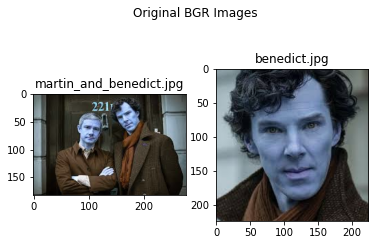

In [1]:
# including the required libraries
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
#import cvlib as cvl
from mtcnn.mtcnn import MTCNN
from sklearn.cluster import KMeans
from sklearn.neighbors import BallTree
from sys import getsizeof
import copy
import pickle

# reading the images
img1 = cv.imread('martin_and_benedict.jpg')
img2 = cv.imread('benedict.jpg')

# Getting copy of images
img1_copy = cv.imread('martin_and_benedict.jpg')
img2_copy = cv.imread('benedict.jpg')

#printing the dimensions of the images
print('Dimensions of first image',np.shape(img1))
print('Dimensions of second image',np.shape(img2))

#plotting the orginal BGR images
fig, (ax1, ax2) = plt.subplots(1, 2,)
fig.suptitle('Original BGR Images')
ax1.imshow(img1)
ax1.set_title('martin_and_benedict.jpg')
ax2.imshow(img2)
ax2.set_title('benedict.jpg')
type(img1)

## Now trying all the above steps by making use of CQSIFT

In [2]:
# Quantization function for saturation channel
def S_quantization(s):
    if 0<=s<=0.2:
        return 0
    elif 0.2<s<=0.4:
        return 1
    elif 0.4<s<=0.7:
        return 2
    else:
        return 3
S_q_vect = np.vectorize(S_quantization)

In [3]:
# Quantization function for value channel
def V_quantization(v):
    if 0<=v<=100:
        return 0
    elif 100<v<=150:
        return 1
    elif 150<v<=200:
        return 2
    else:
        return 3
V_q_vect = np.vectorize(V_quantization)

In [4]:
# HSV 2 the new single channel color space conversion
def HSV2CQGray(im_hsv):
    H = im_hsv[:,:,0]
    S = im_hsv[:,:,1]
    V = im_hsv[:,:,2]
    Qs = S_q_vect(S)
    Qv = V_q_vect(V)
    QsQv = np.multiply(Qs,Qv)
    QsQvH = np.multiply(QsQv,H)
    QvS = np.multiply(Qv,S)
    L = QsQvH + QvS + V 
    # Normalizing to convert to unint8- a requirement by opencv's SIFT implementation
    L = np.round((L/3498)*256).astype(np.uint8)
    return L

numpy.ndarray

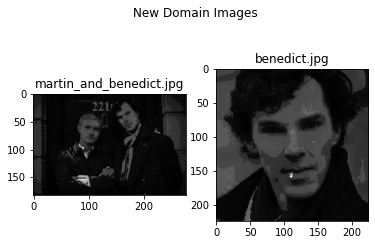

In [5]:
im_hsv1 = cv.cvtColor(img1,cv.COLOR_BGR2HSV)
im_hsv2 = cv.cvtColor(img2,cv.COLOR_BGR2HSV)
im_L1 = HSV2CQGray(im_hsv1)
im_L2 = HSV2CQGray(im_hsv2)

#plotting the orginal BGR images
fig, (ax1, ax2) = plt.subplots(1, 2,)
fig.suptitle('New Domain Images')
ax1.imshow(im_L1,cmap='gray')
ax1.set_title('martin_and_benedict.jpg')
ax2.imshow(im_L2,cmap='gray')
ax2.set_title('benedict.jpg')
type(img1)

In [6]:
np.max(im_L2)

102

# Converting to RGB since opencv takes BGR as input 

Text(0.5, 1.0, 'benedict.jpg')

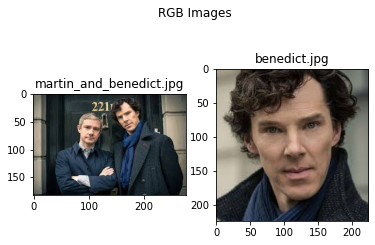

In [7]:
#Converting to rgb- since opencv takes images in BGR format

rgb1= cv.cvtColor(img1,cv.COLOR_BGR2RGB)
rgb2= cv.cvtColor(img2,cv.COLOR_BGR2RGB)

rgb1_copy= copy.deepcopy(rgb1)
rgb2_copy= copy.deepcopy(rgb2)

gray1 = cv.cvtColor(rgb1,cv.COLOR_RGB2GRAY)
gray2 = cv.cvtColor(rgb2,cv.COLOR_RGB2GRAY)

#plotting the RGB images
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('RGB Images')
ax1.imshow(rgb1)
ax1.set_title('martin_and_benedict.jpg')
ax2.imshow(rgb2)
ax2.set_title('benedict.jpg')

# Detect keypoint, get their descriptors and display them on the image

Text(0.5, 1.0, 'benedict.jpg')

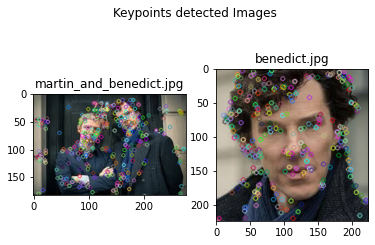

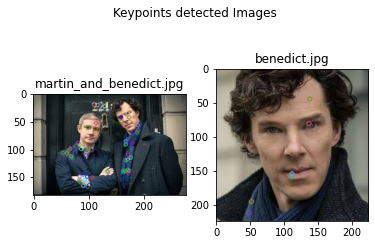

In [8]:
#Creating sift object using the papers's default values
# nfeatures = 0,
# nOctaveLayers = 3, no of times the blur doubles 
# contrastThreshold = 0.04, for the 
# edgeThreshold = 10, the ratio of eigen values of the top4 values of Hessian matrix, 
# higher edge threshold means more sensitivity of the key points to noise.
# sigma = 1.6 intial blur factor during blurring
sift = cv.xfeatures2d.SIFT_create()

#Getting the keypoints and getting 128 integer descriptors from each of the key points
kp1, des1 = sift.detectAndCompute(rgb1,None)
kp2, des2 = sift.detectAndCompute(rgb2,None)

# Repeating the same for grayscale
kp_gray1, des_gray1 = sift.detectAndCompute(gray1,None)
kp_gray2, des_gray2 = sift.detectAndCompute(gray2,None)


# Repeating the same with the new colorspace derived from HSV
kp_L1, des_L1 = sift.detectAndCompute(im_L1,None)
kp_L2, des_L2 = sift.detectAndCompute(im_L2,None)


#Drawing keypoints on the RGB image, and return that image
img_with_kp1=cv.drawKeypoints(rgb1,kp1,img1)
img_with_kp2=cv.drawKeypoints(rgb2,kp2,img2)

#Drawing keypoints on the CQSIFT - image, and return that image
img_with_kp_L1=cv.drawKeypoints(rgb1_copy,kp_L1,img1_copy)
img_with_kp_L2=cv.drawKeypoints(rgb2_copy,kp_L2,img2_copy)


#Showing the keypoints in the RGB image
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Keypoints detected Images')
ax1.imshow(img_with_kp1)
ax1.set_title('martin_and_benedict.jpg')
ax2.imshow(img_with_kp2)
ax2.set_title('benedict.jpg')


#Showing the keypoints in the RGB image
fig2, (ax21, ax22) = plt.subplots(1, 2)
fig2.suptitle('Keypoints detected Images')
ax21.imshow(img_with_kp_L1)
ax21.set_title('martin_and_benedict.jpg')
ax22.imshow(img_with_kp_L2)
ax22.set_title('benedict.jpg')

# Understanding how descriptors and keypoints are returned

In [9]:
descriptor_length = len(des1[0])
print(descriptor_length)
des1

128


array([[  0.,   2.,  10., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   2.,   8.],
       [  0.,   0.,  10., ...,   0.,   0.,   2.],
       ...,
       [ 49.,   4.,   0., ...,   0.,   0.,  17.],
       [ 87., 140.,   2., ...,   3.,   2.,   1.],
       [ 20.,   1.,   1., ...,   0.,   0.,   0.]], dtype=float32)

In [10]:
# https://docs.opencv.org/3.4/d2/d29/classcv_1_1KeyPoint.html

import inspect # helps in looking for class values
var = [i for i in dir(kp1[0]) if not callable(i)]
common_var = [i for i in dir(object()) if not callable(i)]
set(var)-set(common_var)

{'angle', 'class_id', 'convert', 'octave', 'overlap', 'pt', 'response', 'size'}

In [11]:
print('Dimensions of Descriptor array of first image in rgb',np.shape(des1))
print('Dimensions of Descriptor array of second image in rgb',np.shape(des2))
print('Dimensions of Descriptor array of first image in grayscale',np.shape(des_gray1))
print('Dimensions of Descriptor array of second image in grayscale',np.shape(des_gray2))
print('Dimensions of Descriptor array of first image in CQSIFT',np.shape(des_L1))
print('Dimensions of Descriptor array of second image in CQSIFT',np.shape(des_L2))


Dimensions of Descriptor array of first image in rgb (352, 128)
Dimensions of Descriptor array of second image in rgb (275, 128)
Dimensions of Descriptor array of first image in grayscale (329, 128)
Dimensions of Descriptor array of second image in grayscale (264, 128)
Dimensions of Descriptor array of first image in CQSIFT (91, 128)
Dimensions of Descriptor array of second image in CQSIFT (11, 128)


#### The above proves that the internal SIFT for opencv does not convert RGB to grayscale to get the SIFT keypoints . It Also proves that CQSIFT computes very few key points. And though the internal implmentation of SIFT is a black-box, it performs well.

# Using the FLANN KD-TREE matching provided by opencv

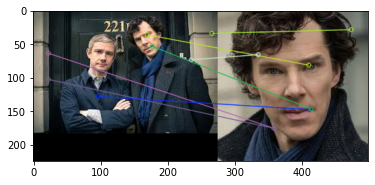

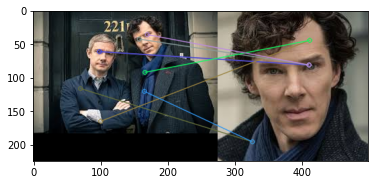

(<matplotlib.image.AxesImage at 0x2b49e01c1c8>, None)

In [12]:
# Brute force matcher
#bf = cv.BFMatcher()

# Finds matches using knearest neighbour approach , where we take k =2 for the lowe ratio test
# here we match each keypoint from one image to a maximum of 2 key points from the other image, thereby reducing keypoint matches
#matches = bf.knnMatch(des1,des2,k=2)



# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 10)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
matches_L = flann.knnMatch(des_L1,des_L2,k=2)


# Apply ratio test
# for each pair of key point matches, append keypoints only if the better key point is atleast at a lesser
# distance than 75% of the distance with the second best key point. i.e. we are able to distinguish clearly which keypoint pair
# better.- since we map each key point to 2 other keypoints
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        

good_L = []
for m,n in matches_L:
    if m.distance < 0.75*n.distance:
        good_L.append([m])        

# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(rgb1,kp1,rgb2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img4 = cv.drawMatchesKnn(rgb1_copy,kp_L1,rgb2_copy,kp_L2,good_L,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3),plt.show()
plt.imshow(img4),plt.show()

# Testing the face detection library (MTCNN)

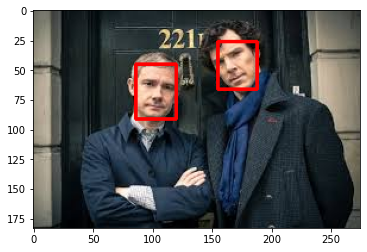

In [13]:
# To solve the problem of non face_pts being matched to face pts, I decided to kep two set of keypoints one for face 
# and one for non face.

# Initially I had made use of cv2's inbuilt face like classifier- the casacaded haar-like (features which compute difference of 
# the sum of pixels of areas inside a rectangle-they are fast) classifier. But it was creating too many false positives and 
# was unable to detect side view of faces .So after much looking around i found mtcnn. 
# MTCNN(Multi-task Cascaded Convolutional Neural Networks) is also a cascaded classifier and is used especially for face 
# detection. It gives alot of information but our focus here is only at getting the face bounding box.
detector = MTCNN()
temp =rgb1.copy()
faces = detector.detect_faces(temp)
for result in faces:
    x, y, w, h = result['box']
    x1, y1 = x + w, y + h
    color_of_box= (255, 0, 0)
    cv.rectangle(temp, (x, y), (x1, y1), color_of_box , 2)
plt.imshow(temp)

# Catching frames from Video

23.976023976023978
True
14524
[{'box': [342, 84, 96, 143], 'confidence': 0.9996877908706665, 'keypoints': {'left_eye': (348, 144), 'right_eye': (378, 137), 'nose': (348, 172), 'mouth_left': (361, 204), 'mouth_right': (383, 200)}}, {'box': [311, 162, 32, 43], 'confidence': 0.9996267557144165, 'keypoints': {'left_eye': (318, 179), 'right_eye': (333, 183), 'nose': (320, 189), 'mouth_left': (315, 195), 'mouth_right': (328, 199)}}, {'box': [183, 112, 37, 44], 'confidence': 0.9968141913414001, 'keypoints': {'left_eye': (201, 133), 'right_eye': (217, 133), 'nose': (211, 144), 'mouth_left': (199, 148), 'mouth_right': (213, 148)}}]


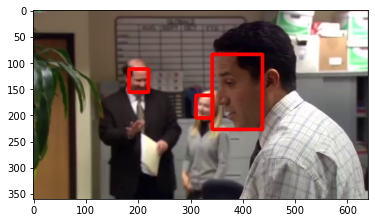

In [14]:
# Here instead of creating a database, I am making use of a simple compilation video i found on youtube, 
# I smaple frames/images from it on 1 frame/sec
db  =cv.VideoCapture('Best_of_Michael_scott.mp4')
fps = db.get(cv.CAP_PROP_FPS)
print(fps)
ret, frame = db.read()
print(ret)
frame_count = int(db.get(cv.CAP_PROP_FRAME_COUNT))
print(frame_count)
temp = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
# this dects faces using MTCNN
faces = detector.detect_faces(temp)
print(faces)
for face in faces:
    x1, y1, w, h =face['box']
    cv.rectangle(temp, (x1, y1), (x1+w, y1+h), (255, 0, 0), 5)
plt.imshow(temp)

# Sampling from frame & getting Keypoints & Descriptor 
### Keypoints are divided to face or non_face

In [15]:
# This function is for checking, whether a point (x,y) lies in a rectangle enclosed with top left corner (x1,y1) and bottom right 
# corner (x2,y2)
def Face_check(x1, y1, x2, y2, x, y) : 
    if (x > x1 and x < x2 and y > y1 and y < y2) : 
        return True
    else : 
        return False

In [16]:
# This is instrumental later on for sampling images/frames out of the video to create the database
skips = round(fps) # to get 1 frames per second
skips

24

In [17]:
# Now for each frames (frame postion is the key) we compute
# 1. keypoints that belong to a face
face_kps ={}

# 2. keypoints that dont' belong to a face
non_face_kps = {}

# 3. keypoint descriptors that belong to a face
face_descs = {}

# 4. keypoint descriptors that do not belong to a face
non_face_descs = {}

# Additionally we find
# all face keypoint descriptors combined
face_all_descs = []

# all non face keypoint descriptors combined
non_face_all_descs = []

for frame_pos in range(1,frame_count+1,skips): # skipping 24 frames to get next second's frame
    
    # set pointer to collect next frame at position frame_pos
    db.set(cv.CAP_PROP_POS_FRAMES, frame_pos)
    
    # Reading frame flag & frame
    ret,frame = db.read()
    temp = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
    faces = detector.detect_faces(temp)
#     temp = cv.cvtColor(frame,cv.COLOR_RGB2HSV)
#     temp = HSV2CQGray(temp)
    

    kps, descs = sift.detectAndCompute(temp,None)
    
    # initializing arrays for image at frame_pos
    face_kps[frame_pos] = []
    non_face_kps[frame_pos] = []
    face_descs[frame_pos] = []
    non_face_descs[frame_pos] = []
    
    # For all key
    for kp_ptr in range(len(kps)):
        kp = kps[kp_ptr]
        desc  = descs[kp_ptr]
        kp_x,kp_y = kp.pt
        face_flag = False
    
        # checking for each face, if the key point lies in it
        for face in faces:
            x1,y1,width,height = face['box']
            x2,y2 = x1+width,y1+height
            if(Face_check(x1,y1,x2,y2,kp_x,kp_y)):
                face_flag = True
                break
        if(face_flag):
            face_kps[frame_pos].append(kp)
            face_descs[frame_pos].append(desc)
            face_all_descs.append(desc)
        else:
            non_face_kps[frame_pos].append(kp)
            non_face_descs[frame_pos].append(desc)
            non_face_all_descs.append(desc)

In [18]:
# no of frames sampled
len(face_kps.keys())

606

In [19]:
# computing average no. of embeddings using total number of descriptors to the no of images having the decriptors
# for face descriptors
face_avg = len(face_all_descs)/len(face_descs.keys())

# and face descriptors
non_face_avg = len(non_face_all_descs)/len(non_face_descs.keys())
print(face_avg,non_face_avg)

36.166666666666664 444.53960396039605


# Applying kmeans

In [27]:
# Taking square root of average as k, since in my opinion splitting group by taking square roots usually gets good results
k_for_face =  max(map(len,face_descs.values()))//2 #round(face_avg)#round(face_avg**0.5)
k_for_non_face = round(non_face_avg)//4
print(k_for_face,k_for_non_face)

75 111


In [28]:
# computing the global kmeans for all descriptors inside and outside faces.
face_visual_codebook = KMeans(n_clusters =k_for_face, init='k-means++').fit(face_all_descs)
non_face_visual_codebook = KMeans(n_clusters =k_for_non_face, init='k-means++').fit(non_face_all_descs)

# VLAD Descriptors

In [29]:
# descriptor for each image, key = frame pos
vlad_face_descriptors = {}
vlad_non_face_descriptors = {}

# For each image selected previously
for frame_pos in range(1,frame_count+1,skips):
    
    # using numpy array format to allow logical indexing - like in matlab.
    # converting to float- since double threw an error at some point.
    im_descs = np.array(face_descs[frame_pos]).astype(np.float)
    
    # if an only if there is a face in the image
    if(len(im_descs)!=0):
        
        # predicting the keypoint descriptor labels for the global kmeans
        
        face_label_predictions = face_visual_codebook.predict(im_descs)
        # Getting cluster center for the global kmeans
        
        face_centers = face_visual_codebook.cluster_centers_
        
        # intitializing the VLAD dimension of |k|,|descriptor| 
        vlad = np.zeros([k_for_face,descriptor_length])
        
        # For each of the clusters
        for cluster_idx in range(k_for_face):
            
            # If there exists a single point that belongs to that cluster
            if(np.sum(face_label_predictions == cluster_idx)>0):
                
                # finding edit_distance of each keypoint from it's predicted cluster center, and summing it up for
                # each dimension in the descriptor array
                vlad[cluster_idx] = np.sum(im_descs[face_label_predictions == cluster_idx,:]-face_centers[cluster_idx],axis=0)
    
        # flattening the array
        vlad = vlad.flatten()
        # map e belong to vlad to  sign(e)*(abs(e))^0.5 
        vlad = np.sign(vlad)*np.sqrt(np.abs(vlad))
        # dividing each element by square of sum of squares of all elements
        vlad_face_descriptors[frame_pos] = vlad/(sum(map(lambda x: x*x ,vlad))**0.5)
    
    
    #Repeating the same steps for non face attributes
    im_descs = np.array(non_face_descs[frame_pos]).astype(np.float)
    # if an only if there is something other than a face in the image
    if(len(im_descs)!=0):
        non_face_label_predictions = non_face_visual_codebook.predict(im_descs)
        non_face_centers = non_face_visual_codebook.cluster_centers_
        vlad = np.zeros([k_for_non_face,descriptor_length])
        for cluster_idx in range(k_for_non_face):
            if np.sum(non_face_label_predictions == cluster_idx)>0:
                vlad[cluster_idx] = np.sum(im_descs[non_face_label_predictions == cluster_idx,:]-non_face_centers[cluster_idx],axis=0)
        vlad = vlad.flatten()
        vlad = np.sign(vlad)*np.sqrt(np.abs(vlad))
        vlad_non_face_descriptors[frame_pos] = vlad/(sum(map(lambda x: x*x ,vlad))**0.5)


In [30]:
vlad_face_descriptors[1825]

array([ 0.        ,  0.        ,  0.        , ..., -0.02510163,
       -0.02028069, -0.00741561])

In [31]:
np.shape(vlad_face_descriptors[1]),type(vlad_face_descriptors[1])

((9600,), numpy.ndarray)

In [32]:
np_vlad_face_descriptors = np.asarray(list(vlad_face_descriptors.values()))
np_vlad_non_face_descriptors = np.asarray(list(vlad_non_face_descriptors.values()))
np_vlad_face_descriptors

array([[-0.00881567, -0.01182543,  0.02379579, ..., -0.01063542,
        -0.01448734, -0.00584405],
       [-0.00525295,  0.02200809,  0.00433274, ...,  0.0175535 ,
        -0.01288685, -0.00877942],
       [ 0.        ,  0.        ,  0.        , ...,  0.00544673,
        -0.01451817, -0.00975604],
       ...,
       [-0.01500701, -0.02292864, -0.0310088 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# Creating Inverted Tree Index for the high dimensional VLAD tree 

In [33]:
# Number of points at which to switch to brute-force for querying
leaf_size = 40

In [34]:
face_tree = BallTree(np_vlad_face_descriptors,leaf_size)

In [35]:
non_face_tree = BallTree(np_vlad_non_face_descriptors,leaf_size)

In [36]:
print('Size of face SIFT descriptor vs face tree', getsizeof(face_all_descs), 'VS',getsizeof(np_vlad_face_descriptors))
print('Size of non-face SIFT descriptor vs non_face tree', getsizeof(non_face_all_descs), 'VS',getsizeof(np_vlad_non_face_descriptors))

Size of face SIFT descriptor vs face tree 178024 VS 40320112
Size of non-face SIFT descriptor vs non_face tree 2380488 VS 68880496


# Getting Query Image

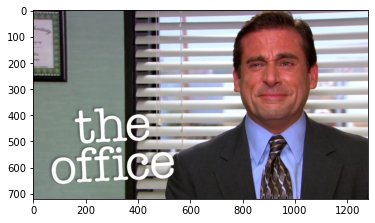

In [300]:
query_image_path = 'michaelscottcry.jpg'
query_image = cv.imread(query_image_path)
query_image = cv.cvtColor(query_image,cv.COLOR_BGR2RGB)
plt.imshow(query_image)

# Getting Query Image's Keypoints & Descriptors

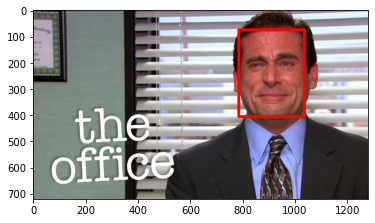

In [301]:
temp =query_image.copy()
faces = detector.detect_faces(temp)
for result in faces:
    x, y, w, h = result['box']
    x1, y1 = x + w, y + h
    color_of_box= (255, 0, 0)
    cv.rectangle(temp, (x, y), (x1, y1), color_of_box , 10)
plt.imshow(temp)
query_kps, query_descs = sift.detectAndCompute(query_image,None)

# Separating features into face and non-face

In [302]:
query_face_kps = []
query_non_face_kps = []
query_face_descs = []
query_non_face_descs = []
for kp_idx in range(len(query_kps)):
    kp_x,kp_y = query_kps[kp_idx].pt
    face_flag = False
    for face in faces:
        x1,y1,width,height = face['box']
        x2,y2 = x1+width,y1+height
        if(Face_check(x1,y1,x2,y2,kp_x,kp_y)):
            face_flag = True
            break
    if(face_flag):
        query_face_kps.append(query_kps[kp_idx])
        query_face_descs.append(query_descs[kp_idx])
    else:
        query_non_face_kps.append(query_kps[kp_idx])
        query_non_face_descs.append(query_descs[kp_idx])
query_face_descs = np.array(query_face_descs).astype(np.float)
query_non_face_descs = np.array(query_non_face_descs).astype(np.float)

In [303]:
len(query_face_kps),len(query_non_face_kps)

img_with_kp2=cv.drawKeypoints(query_image,query_face_kps,img2)

# Getting VLAD descriptors for the query image

In [304]:
query_face_vlads = []
query_non_face_vlads = []
if query_face_descs.size > 0:
    query_face_label_predictions = face_visual_codebook.predict(query_face_descs)
    face_centers = face_visual_codebook.cluster_centers_
    vlad = np.zeros([k_for_face,descriptor_length])
    for cluster_idx in range(k_for_face):
        if(np.sum(query_face_label_predictions == cluster_idx)>0):
            vlad[cluster_idx] = np.sum(query_face_descs[query_face_label_predictions == cluster_idx,:]-face_centers[cluster_idx],axis=0)
    vlad = vlad.flatten()
    vlad = np.sign(vlad)*np.sqrt(np.abs(vlad))
    vlad = vlad/(sum(map(lambda x: x*x ,vlad))**0.5)
    query_face_vlads = vlad.reshape(1,k_for_face*descriptor_length)
        
if query_non_face_descs.size > 0:
    query_non_face_label_predictions = non_face_visual_codebook.predict(query_non_face_descs)
    non_face_centers = non_face_visual_codebook.cluster_centers_
    vlad = np.zeros([k_for_non_face,descriptor_length])
    for cluster_idx in range(k_for_non_face):
        if np.sum(query_non_face_label_predictions == cluster_idx)>0:
            vlad[cluster_idx] = np.sum(query_non_face_descs[query_non_face_label_predictions == cluster_idx,:]-non_face_centers[cluster_idx],axis=0)
    vlad = vlad.flatten()
    vlad = np.sign(vlad)*np.sqrt(np.abs(vlad))
    vlad = vlad/(sum(map(lambda x: x*x ,vlad))**0.5)
    query_non_face_vlads = vlad.reshape(1,k_for_non_face*descriptor_length)

In [305]:
np.shape(query_face_vlads),np.shape(query_non_face_vlads)

((1, 9600), (1, 14208))

# Querying the face & Non face images

In [306]:
no_of_results_required = 30

In [307]:
if query_face_descs.size > 0:
    face_dist, face_ind = face_tree.query(query_face_vlads,no_of_results_required)
if query_non_face_descs.size > 0:
    non_face_dist, non_face_ind = non_face_tree.query(query_non_face_vlads,no_of_results_required)

In [308]:
non_face_ind

array([[227, 228, 220, 229, 224, 234, 222, 223, 226, 235, 230, 218, 233,
        219, 225, 354, 236, 231, 232,  78, 221,  57,  52,  51,  53,  67,
         68,  62,  70,  66]], dtype=int64)

In [309]:
face_key_list = list(vlad_face_descriptors.keys())
non_face_key_list = list(vlad_non_face_descriptors.keys())
len(face_key_list),len(non_face_key_list)

(525, 606)

# Getting face matched images

<Figure size 432x288 with 0 Axes>

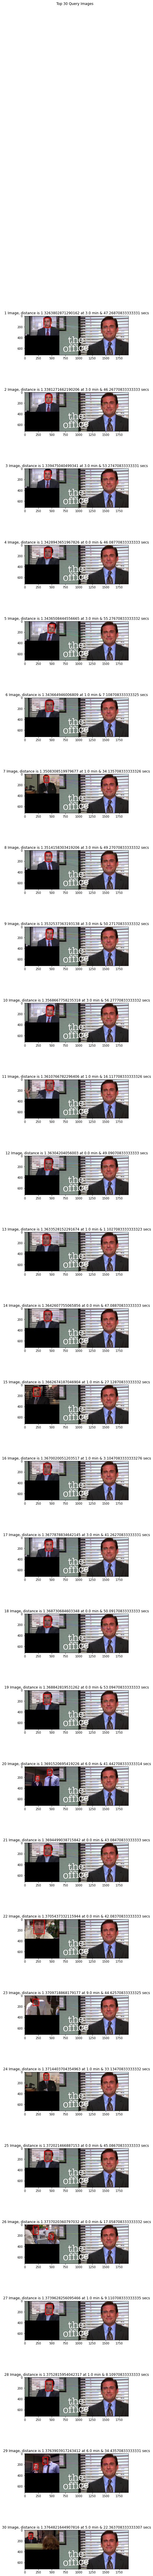

In [310]:
plt.tight_layout()
if query_face_descs.size > 0:
    fig, axes = plt.subplots(no_of_results_required, 1,figsize=[6.4, 4.8*no_of_results_required])
    fig.suptitle('Top '+str(no_of_results_required)+' Query Images')
    ax_ctr= 0
    for idx in face_ind[0]:
        frame_no = int(face_key_list[idx])
        db.set(cv.CAP_PROP_POS_FRAMES, int(frame_no))
        frame_time = abs((frame_no)/fps)
        time_min = (frame_time)//(60)
        time_sec = (frame_time)%(60)
        ret,frame = db.read()
        frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
        ttl = str(ax_ctr+1)+' Image, distance is '+str(face_dist[0][ax_ctr]) +' at '+str(time_min)+' min & '+str(time_sec)+' secs'
        temp =frame.copy()
        faces = detector.detect_faces(temp)
        for result in faces:
            x, y, w, h = result['box']
            x1, y1 = x + w, y + h
            color_of_box= (255, 0, 0)
            cv.rectangle(temp, (x, y), (x1, y1), color_of_box , 10)
        matches = flann.knnMatch(np.array(face_descs[frame_no]),query_face_descs.astype('float32'),k=2)
        good = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good.append([m])

        combined = cv.drawMatchesKnn(temp,face_kps[frame_no],query_image,query_face_kps,good,(255,0,0),flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        axes[ax_ctr].imshow(combined)
        axes[ax_ctr].set_title(ttl)
        ax_ctr = ax_ctr+1


In [311]:
np.array(face_descs[face_key_list[168]])[0]

array([ 60.,   0.,   0.,   2.,  20.,   0.,   0.,   3., 159.,   0.,   0.,
         0.,   0.,   0.,   0.,  25., 114.,   0.,   0.,   5.,  22.,  22.,
         5.,  11.,  10.,   9.,  12.,  12.,  12.,  10.,  12.,  24.,  76.,
         0.,   0.,   1.,  20.,   3.,   2.,  16., 159.,  28.,   4.,   0.,
         0.,   0.,   0.,  27., 119.,  27.,  21.,  20.,  22.,   5.,   2.,
         7.,   2.,   8.,  15.,  16.,  25.,  30.,  20.,   3.,  28.,   1.,
         0.,   0.,   4.,  13.,  40.,  40., 159., 142.,  53.,   0.,   0.,
         0.,   3.,  21., 116., 159., 105.,   5.,   1.,   0.,   2.,   6.,
        60.,  20.,   1.,   1.,  10.,  46.,  27.,  17.,   0.,   0.,   0.,
         0.,   0.,   9.,  23.,   6.,  10.,  19.,  10.,   0.,   0.,   1.,
        19.,  20., 159.,  94.,   9.,   0.,   0.,   0.,   2.,  11., 100.,
        86.,  14.,   0.,   0.,   9.,  10.,   5.], dtype=float32)

In [312]:
query_face_descs.astype('float32')

array([[ 60.,  12.,   0., ...,   0.,  33., 104.],
       [  1.,   0.,   0., ...,   0.,  41.,  97.],
       [ 10.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   5.,   2.,   6.],
       [ 43.,  35.,   1., ..., 118.,   2.,   0.],
       [ 18.,  25.,  29., ...,  13.,  16.,   7.]], dtype=float32)

# Getting non-face objects matched image

In [ ]:
fig, axes = plt.subplots(no_of_results_required//2, 2,figsize=[12.8, 4.8*no_of_results_required])
fig.suptitle('Top '+str(no_of_results_required)+' Query Images')
ax_ctr= 0
ax_ctr2=0
for idx in non_face_ind[0]:
    frame_no = int(non_face_key_list[idx])
    db.set(cv.CAP_PROP_POS_FRAMES, int(frame_no))
    time_min = (frame_no//skips)//60
    time_sec = (frame_no//skips)%60
    ret,frame = db.read()
    frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
    ttl = str(ax_ctr+1)+' Image, distance is '+str(non_face_dist[0][ax_ctr]) +' at '+str(time_min)+' min & '+str(time_sec)+' secs'
    matches = flann.knnMatch(np.array(non_face_descs[frame_no]),query_non_face_descs.astype('float32'),k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])
            
    combined = cv.drawMatchesKnn(frame,non_face_kps[frame_no],query_image,query_non_face_kps,good,(255,0,0),flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    
    axes[ax_ctr2][ax_ctr%2].imshow(combined)
    axes[ax_ctr2][ax_ctr%2].set_title(ttl)
    ax_ctr = ax_ctr+1
    ax_ctr2 += (ax_ctr-1)%2

In [273]:
np.array(face_descs[face_key_list[168]])[0]

array([ 60.,   0.,   0.,   2.,  20.,   0.,   0.,   3., 159.,   0.,   0.,
         0.,   0.,   0.,   0.,  25., 114.,   0.,   0.,   5.,  22.,  22.,
         5.,  11.,  10.,   9.,  12.,  12.,  12.,  10.,  12.,  24.,  76.,
         0.,   0.,   1.,  20.,   3.,   2.,  16., 159.,  28.,   4.,   0.,
         0.,   0.,   0.,  27., 119.,  27.,  21.,  20.,  22.,   5.,   2.,
         7.,   2.,   8.,  15.,  16.,  25.,  30.,  20.,   3.,  28.,   1.,
         0.,   0.,   4.,  13.,  40.,  40., 159., 142.,  53.,   0.,   0.,
         0.,   3.,  21., 116., 159., 105.,   5.,   1.,   0.,   2.,   6.,
        60.,  20.,   1.,   1.,  10.,  46.,  27.,  17.,   0.,   0.,   0.,
         0.,   0.,   9.,  23.,   6.,  10.,  19.,  10.,   0.,   0.,   1.,
        19.,  20., 159.,  94.,   9.,   0.,   0.,   0.,   2.,  11., 100.,
        86.,  14.,   0.,   0.,   9.,  10.,   5.], dtype=float32)

In [ ]:
query_face_descs.astype('float32')